In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    0.25: load_data('../stats/fpm_6_x0.25.json'),
    0.5: load_data('../stats/fpm_6_x0.5.json'),
    1: load_data('../stats/fpm_6_x1.json'),
    2: load_data('../stats/fpm_6_x2.json'),
    3: load_data('../stats/fpm_6_x3.json'),
    # 'x16': load_data('../stats/fpm_5_2D_x4.json'),
    # 'x25': load_data('../stats/fpm_4_2D_x5.json')
    # 'x64': load_data('../stats/fpm_4_2D_x8.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
from fpm_6 import make_model

cell_size_multiplier = 2
model = make_model(cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 2


num sticking: 0
num sliding: 0
num open: 0
num trans: 528


In [3]:
mat_idx = 15
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

101


In [4]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1
model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

# model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = model.bmat.copy()
rhs = model.linear_system[1]
# rhs[:] = 1

22
63
441
2


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


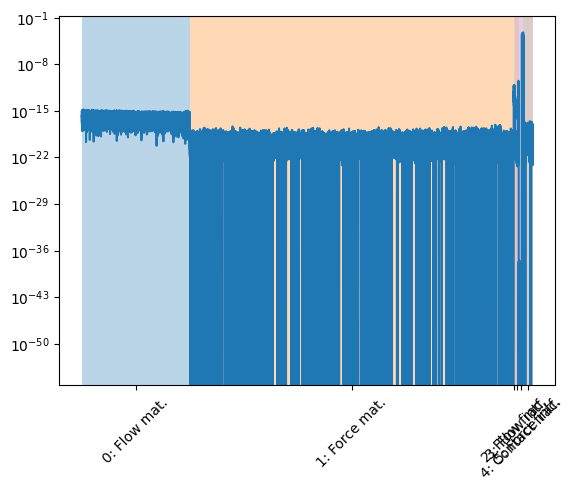

In [5]:
J.color_local_rhs(J.local_rhs(rhs))

In [6]:
# model.bmat.color_spy()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


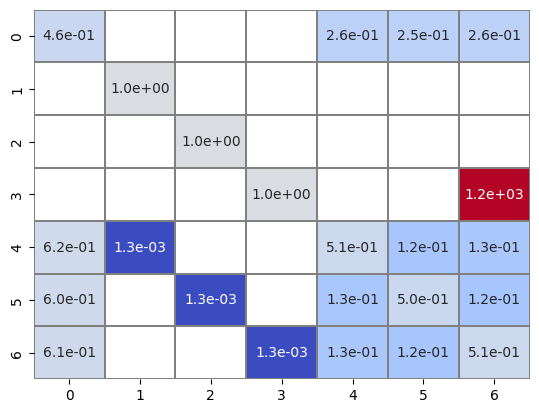

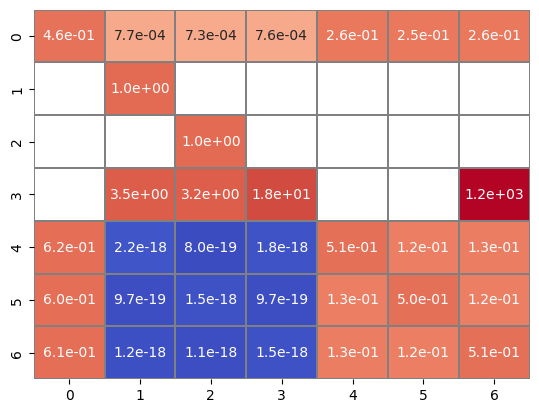

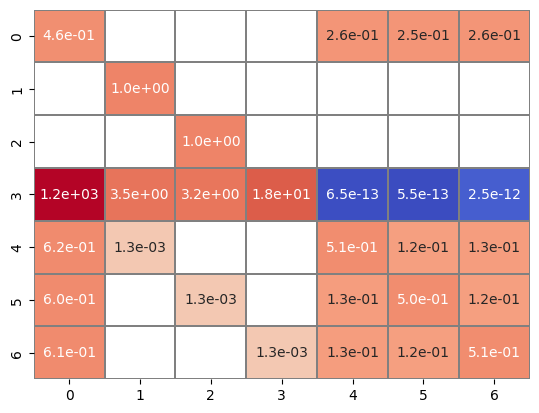

In [7]:
from mat_utils import *

# J55_inv = inv_block_diag(J[[5]].mat, nd=model.nd)
J55_inv = inv(J[[5]].mat)
Qright = J.empty_container()
Qright.mat = csr_ones(Qright.shape[0])
Qright[5, 4] = -J55_inv @ J[5, 4].mat * 1e0
# Qright[5, 4] = -J[5, 4].mat * 1e0


Qleft = J.empty_container()
Qleft.mat = csr_ones(Qleft.shape[0])
Qleft[4, 5] = -J[4, 5].mat @ J55_inv * 1e0

JQright = J.empty_container()
JQright.mat = J.mat @ Qright.mat

JQleft = J.empty_container()
JQleft.mat = Qleft.mat @ J.mat

J[[1,4,5]].plot_max(group=False); plt.show()
JQright[[1,4,5]].plot_max(group=False); plt.show()
JQleft[[1,4,5]].plot_max(group=False)

Solve  took: 44.63
True residual decrease: 1.0779618365566339e-10
PETSc Converged Reason: -3
lambda min: 0.3515139178872552
true true residual: 2.1645932848111496e-09


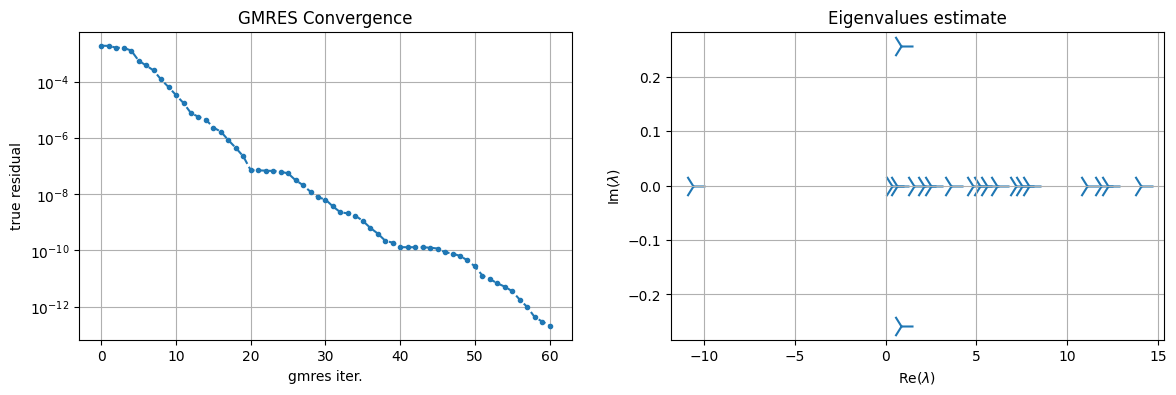

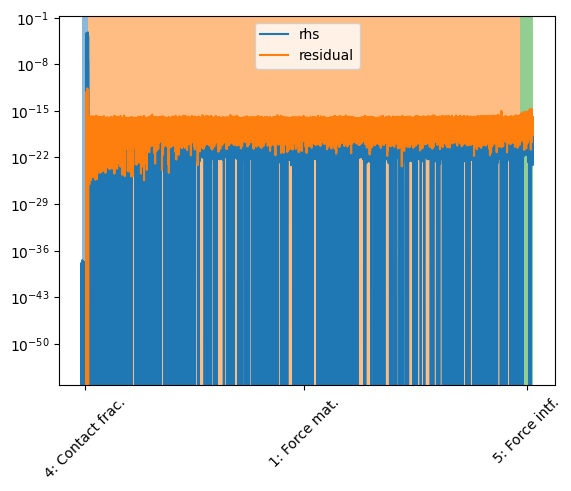

In [15]:
from block_matrix import *
from fixed_stress import *
# schema = SolveSchema(
#     groups=[4],
#     solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
#     complement=SolveSchema(
#         groups=[1, 5],
#         solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
#     ),
# )

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    invertor=lambda bmat: csr_zeros(bmat[[4]].mat.shape[0]),
    # only_complement=True,
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: model._fixed_stress.mat,
            invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # invertor=lambda bmat: make_fs(model, bmat).mat,
            # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            # invertor=lambda bmat: make_local_stab_15(bmat=perm_mat, base=2, nd=1),
            invertor_type="physical",
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
    #     ),
    ),
)

bmat_reordered, preconditioner_Qleft = make_solver(schema=schema, mat_orig=JQleft)

rhs_Qleft = bmat_reordered.local_rhs(J.global_rhs(Qleft.mat @ J.local_rhs(rhs)))

sol_Qleft = solve_petsc(
    bmat_reordered.mat,
    preconditioner_Qleft,
    rhs=rhs_Qleft,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
    return_solution=True,
)

Jlocal = J[bmat_reordered.active_groups]

true_residual_left = Jlocal.mat @ sol_Qleft - Jlocal.local_rhs(rhs)
print(
    "true true residual:",
    np.linalg.norm(true_residual_left) / np.linalg.norm(Jlocal.local_rhs(rhs)),
)
plt.show()
bmat_reordered.color_local_rhs(bmat_reordered.local_rhs(rhs), label="rhs")
bmat_reordered.color_local_rhs(true_residual_left, label="residual")
plt.legend()

Solve  took: 45.84
True residual decrease: 1.2176185672452953e-10
PETSc Converged Reason: -3
lambda min: 0.35025076079791956
true true residual: 1.217617441256272e-10


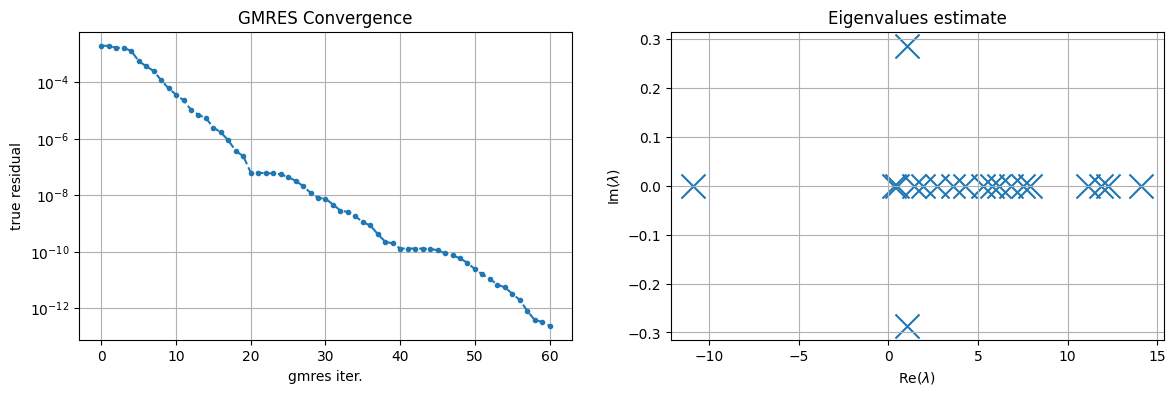

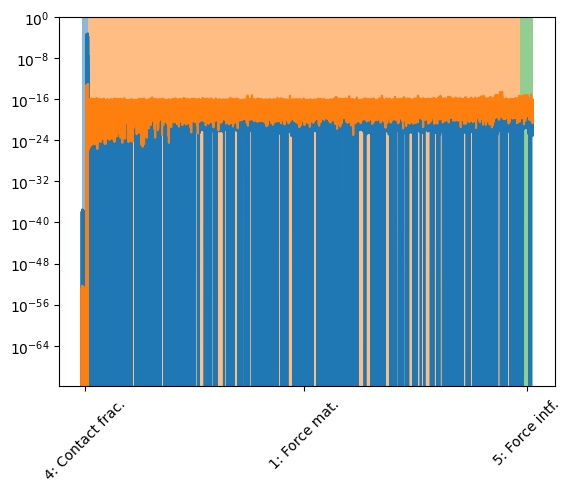

In [16]:
bmat_reordered, preconditioner_Qright = make_solver(schema=schema, mat_orig=JQright)

rhs_Qright = bmat_reordered.local_rhs(rhs)

sol_Qright_transformed = solve_petsc(
    bmat_reordered.mat,
    preconditioner_Qright,
    rhs=rhs_Qright,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
    return_solution=True,
)

Qright_inv = Qright.copy()
Qright_inv[5, 4] = -Qright_inv[5, 4].mat
sol_Qright = bmat_reordered.local_rhs(
    Qright_inv.global_rhs(
        Qright.mat
        @ Qright_inv.local_rhs(bmat_reordered.global_rhs(sol_Qright_transformed))
    )
)

Jlocal = J[bmat_reordered.active_groups]

true_residual_left = Jlocal.mat @ sol_Qright - Jlocal.local_rhs(rhs)
print("true true residual:", np.linalg.norm(true_residual_left) / np.linalg.norm(bmat_reordered.local_rhs(rhs)))
plt.show()
bmat_reordered.color_local_rhs(bmat_reordered.local_rhs(rhs), label='rhs')
bmat_reordered.color_local_rhs(true_residual_left, label='residual')

Both left and right work fine.

Solve  took: 4.53
True residual decrease: 0.0054605344082547915
PETSc Converged Reason: -3
lambda min: 0.0006674930368527586


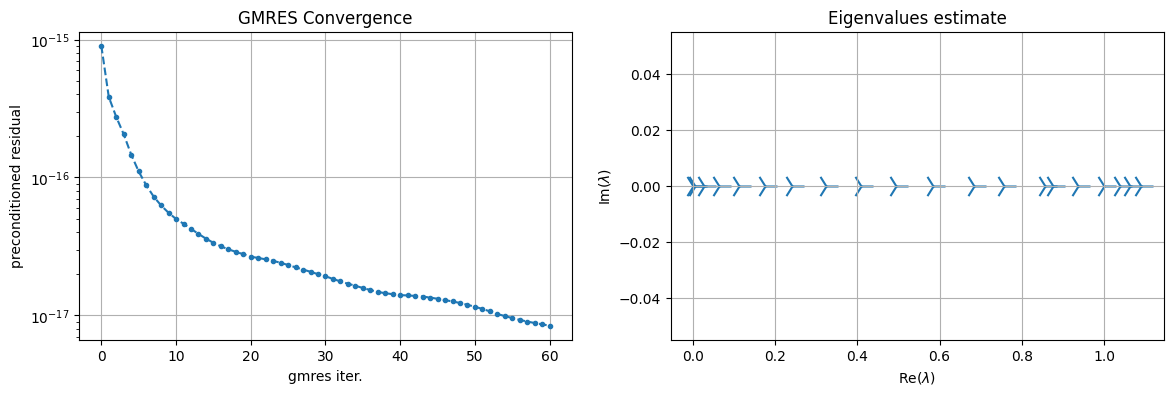

In [31]:
J_44_inv = inv_block_diag(mat=JQleft[[4]].mat, nd=model.nd)
Stab_left = JQleft[[1, 5]].empty_container()
Stab_left.mat = JQleft[[1, 5], 4].mat @ J_44_inv @ JQleft[4, [1, 5]].mat
# Stab_left[5, 1] = 0
# Stab_left.plot_max(group=False);plt.show()
# JQleft[[1,5]].plot_max(group=False);plt.show()
SJQleft = JQleft[[1, 5]].copy()
# SJQleft.mat -= Stab_left.mat
# SJQleft.plot_max(group=False);plt.show()
amg = PetscAMGMechanics(mat=SJQleft.mat, dim=model.nd)
# amg.pc_view()
solve_petsc(SJQleft.mat,amg, rhs=SJQleft.local_rhs(rhs))

In [29]:
amg = PetscAMGMechanics(mat=SJQleft.mat, dim=model.nd)

Solve  took: 11.91
True residual decrease: 3.5420837985016974e-06
PETSc Converged Reason: -3
lambda min: 0.01369893616704339


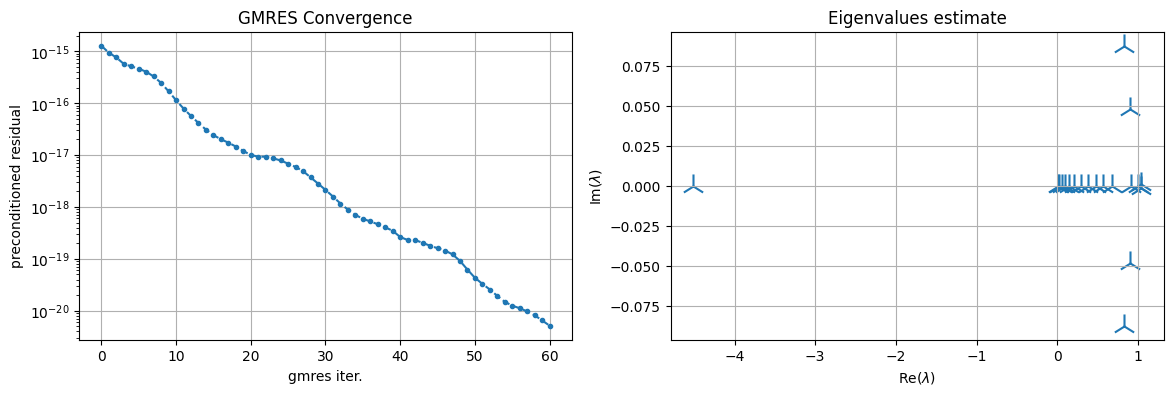

In [26]:
solve_petsc(SJQleft.mat,amg, rhs=SJQleft.local_rhs(rhs))

In [25]:
amg.pc.view()


PC Object: 1 MPI process
  type: gamg
    type is MULTIPLICATIVE, levels=4 cycles=v
      Cycles per PCApply=1
      Using externally compute Galerkin coarse grid matrices
      GAMG specific options
        Threshold for dropping small values in graph on each level =   -1.   -1.   -1.   -1.  
        Threshold scaling factor for each level not specified = 1.
        AGG specific options
          Number of levels of aggressive coarsening 1
          Square graph aggressive coarsening
          Number smoothing steps 1
        Complexity:    grid = 1.00889    operator = 1.00401
  Coarse grid solver -- level 0 -------------------------------
    KSP Object: (mg_coarse_) 1 MPI process
      type: preonly
      maximum iterations=10000, initial guess is zero
      tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
      left preconditioning
      using NONE norm type for convergence test
    PC Object: (mg_coarse_) 1 MPI process
      type: bjacobi
        number of blocks = 1

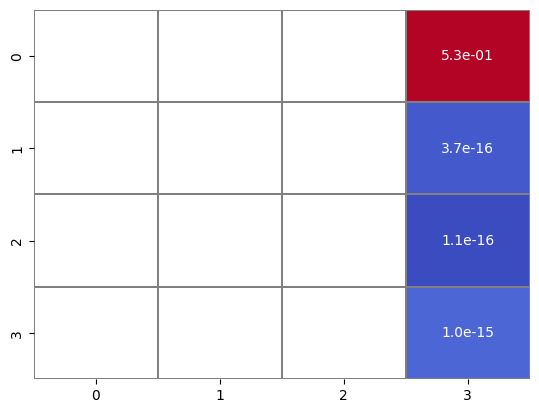

In [54]:
J_44_inv = inv_block_diag(mat=JQright[[4]].mat, nd=model.nd)
Stab_right = JQright[[1, 5]].empty_container()
Stab_right.mat = JQright[[1, 5], 4].mat @ J_44_inv @ JQright[4, [1, 5]].mat
Stab_right.plot_max(group=False)